In [42]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from ssy_model import wc_loglinear_factory

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [14]:
run ../src/wc_ratio_continuous.py

In [3]:
from jax.config import config

# Tell JAX to use 64 bit floats
config.update("jax_enable_x64", True)

In [64]:
ssy = SSY()
wc_loglinear = wc_loglinear_factory(ssy)

# Test wc ratio

In [90]:
zs   = 20
hzs  = 20
hcs  = 20
hλs  = 20
std_devs = 5.0
w_init = jnp.ones(shape=(hλs, hcs, hzs, zs))

In [85]:
# mesh_grids = jnp.meshgrid(*build_grid(ssy, hλs, hcs, hzs, zs, std_devs), indexing='ij')
# x_flat = np.asarray([grid.ravel() for grid in mesh_grids])
# w_init = jnp.asarray([wc_loglinear(x_flat[:, i]) for i in range(x_flat.shape[1])]).reshape((hλs, hcs, hzs, zs))

In [91]:
%%time

out = wc_ratio_continuous(ssy, h_λ_grid_size=hλs, h_c_grid_size=hcs, 
                          h_z_grid_size=hzs, z_grid_size=zs, 
                          num_std_devs=std_devs, mc_draw_size=5000, w_init=w_init, ram_free=20, tol=1e-5)

batch_size = 80000
Beginning iteration


iter = 0, error = 1.0101307575983505
iter = 10, error = 1.0973102357109372
iter = 20, error = 1.162657004822055
iter = 30, error = 1.2097201380707077
iter = 40, error = 1.2419088663819977
iter = 50, error = 1.2622886920679477
iter = 60, error = 1.273400674740472
iter = 70, error = 1.2772525955795118
iter = 80, error = 1.2753757719287364
iter = 90, error = 1.268828020624298
iter = 100, error = 1.257890549055844
iter = 110, error = 1.2407606197734822
iter = 120, error = 1.2096787279465389
iter = 130, error = 1.1430924706763506
iter = 140, error = 1.0020414732807126
iter = 150, error = 0.7655444133631022
iter = 160, error = 0.49719041812247156
iter = 170, error = 0.29326834872858853
iter = 180, error = 0.17426941687534736
iter = 190, error = 0.11047510652306869
iter = 200, error = 0.07480738467714332
iter = 210, error = 0.052979130962285126
iter = 220, error = 0.03848102450982083
iter = 230, error = 0.02831757434978499
iter = 240, error = 0.0209748

In [92]:
out

DeviceArray([[[[114.38838453, 115.78177547, 117.42474172, ...,
                146.53927543, 148.72063798, 150.7662576 ],
               [114.38838453, 115.78177547, 117.42474172, ...,
                146.53927543, 148.72063798, 150.7662576 ],
               [114.38838453, 115.78177547, 117.42474172, ...,
                146.53927543, 148.72063798, 150.7662576 ],
               ...,
               [114.38838453, 115.78177547, 117.42474172, ...,
                146.53927543, 148.72063798, 150.7662576 ],
               [114.38838453, 115.78177547, 117.42474172, ...,
                146.53927543, 148.72063798, 150.7662576 ],
               [114.38838453, 115.78177547, 117.42474172, ...,
                146.53927543, 148.72063798, 150.7662576 ]],

              [[111.52198649, 112.8531667 , 114.42015284, ...,
                142.08098226, 144.14784171, 146.08470162],
               [111.52198649, 112.8531667 , 114.42015284, ...,
                142.08098226, 144.14784171, 146.08470162],
  

In [93]:
def wc_func(x):
    return jit_map_coordinates(out, x)

In [94]:
(h_λ_grid, h_c_grid, h_z_grid, z_grid) = build_grid(ssy, hλs, hcs, hzs, zs, std_devs)

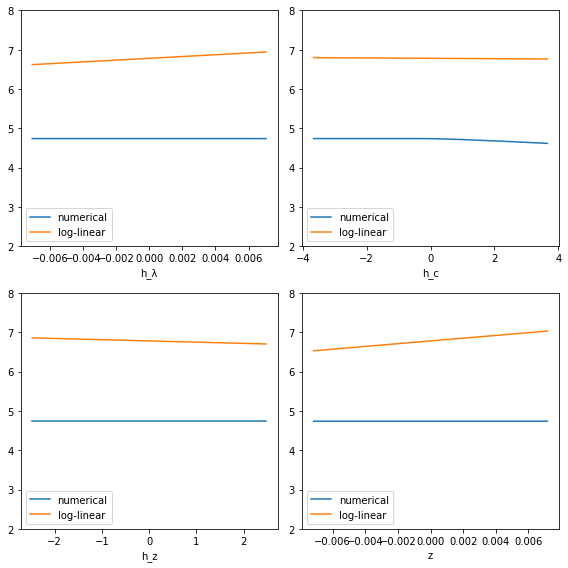

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

grids = (h_λ_grid, h_c_grid, h_z_grid, z_grid)
titles = 'h_λ', 'h_c', 'h_z', 'z'

for pos, grid, title in zip(range(4), grids, titles):
    ax = axes.flatten()[pos]
    y1 = np.empty_like(grid)
    y2 = np.empty_like(grid)

    for i, val in enumerate(grid):
        x = np.zeros(4)
        x[pos] = val
        y1[i] = np.log(wc_func(x)) 
        y2[i] = wc_loglinear(x)

    ax.plot(grid, y1, label='numerical')
    ax.plot(grid, y2, label='log-linear')
    ax.set_xlabel(title)
    ax.set_ylim(2, 8)
    ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

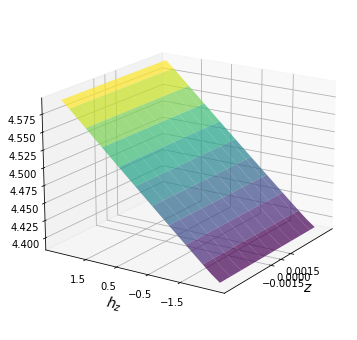

In [96]:
xg = z_grid
yg = h_z_grid
x, y = np.meshgrid(xg, yg)

z = out[int(hλs/2), int(hcs/2), :, :]


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,
                y,
                np.log(z.T),
                rstride=2, cstride=2,
                cmap=cm.viridis,
                alpha=0.7,
                linewidth=0.25)

ax.set_xlabel('$z$', fontsize=14)
ax.set_ylabel('$h_z$', fontsize=14)
ax.set_xticks((-0.0015, 0, 0.0015))
ax.set_yticks((-1.5, -0.5, 0.5, 1.5))

ax.view_init(18, -147)

plt.show()

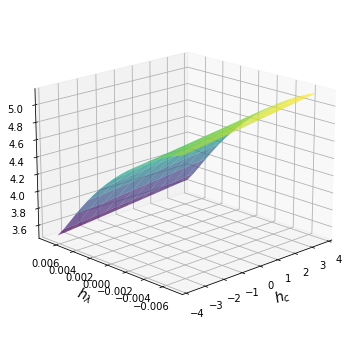

In [97]:
xg = h_c_grid
yg = h_λ_grid
x, y = np.meshgrid(xg, yg)

z = out[:, :, int(hzs/2), int(zs/2)]


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,
                y,
                np.log(z.T),
                rstride=2, cstride=2,
                cmap=cm.viridis,
                alpha=0.7,
                linewidth=0.25)
#ax.set_zlim(-0.5, 1.0)
ax.set_xlabel('$h_c$', fontsize=14)
ax.set_ylabel('$h_\lambda$', fontsize=14)
ax.view_init(18, -134)
plt.show()

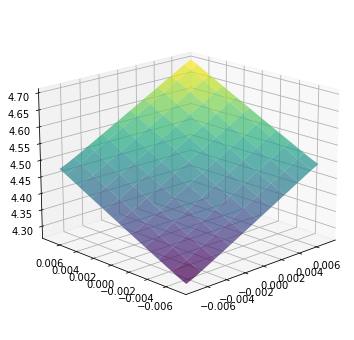

In [98]:
xg = z_grid
yg = h_λ_grid
x, y = np.meshgrid(xg, yg)

z = out[:, int(hcs/2), int(hzs/2), :]


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,
                y,
                np.log(z.T),
                rstride=2, cstride=2,
                cmap=cm.viridis,
                alpha=0.7,
                linewidth=0.25)
#ax.set_zlim(-0.5, 1.0)
ax.view_init(18, -134)
plt.show()